# Premier League Analysis

* The Premier League (legal name: The Football Association Premier League Limited) is the highest level of the men's English football.
* In this project our goal is to use both sql and python in order to make useful tables and graphs about premier league season 2018/2019
* Database source : https://sqlsoccer.com/set-up-scripts/

### 1- Packages

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

### 2- connection to mysql

In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="konodioda307",
  database = "PREMIERSHIP"
)

### 3- Teams Analysis

* Here using sql we will build the premier league Table

In [3]:
table = pd.read_sql_query("""select  rank() over(order by sum(points) desc) as 'Position', t.TEAM_NAME as club, count(TeamID) as MP, sum(wins) as W, sum(draws) as D, sum(loses) as L, sum(points) as Pts,
sum(goals) as GF, sum(goals_received) as GA, (sum(goals) - sum(goals_received)) as GD 
from
(SELECT g.GAME_ID, g.HOME_TEAM_ID as TeamID, g.HOME_SCORE as goals , g.AWAY_SCORE as goals_received,
case  when g.HOME_SCORE > g.AWAY_SCORE then 1 else 0 end as wins,
case when g.HOME_SCORE = g.AWAY_SCORE then 1 else 0 end as draws,
case when g.HOME_SCORE < g.AWAY_SCORE then 1 else 0 end as loses,
case 
 when g.HOME_SCORE > g.AWAY_SCORE then 3 
 when g.HOME_SCORE = g.AWAY_SCORE then 1
 else 0
 end as points
FROM game g
union all
select gg.GAME_ID ,gg.AWAY_TEAM_ID as TeamID, gg.AWAY_SCORE as goals , gg.HOME_SCORE as goals_received,
case  when gg.AWAY_SCORE > gg.HOME_SCORE then 1 end as wins,
case  when gg.AWAY_SCORE = gg.HOME_SCORE then 1 end as draws,
case  when gg.AWAY_SCORE < gg.HOME_SCORE then 1 end as loses,
case 
 when gg.AWAY_SCORE > gg.HOME_SCORE then 3 
 when gg.AWAY_SCORE = gg.HOME_SCORE then 1 
 else 0
 end as points
from game gg) as v 
join team as t
on t.TEAM_ID = TeamID
group by TeamID order by pts desc""",mydb,
            dtype= {'W':int, 'D':int,'L':int,'Pts': int,'GF':int, 'GA':int, 'GD':int})

<ipython-input-3-43c2805a7a4a>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  table = pd.read_sql_query("""select  rank() over(order by sum(points) desc) as 'Position', t.TEAM_NAME as club, count(TeamID) as MP, sum(wins) as W, sum(draws) as D, sum(loses) as L, sum(points) as Pts,


* **MP**: Matches Played
* **W** : Wins
* **D** : Draws
* **L** : Loses
* **Pts** : Points
* **GF** : Goals For
* **GA** : Goals Against
* **GD** : Goals Difference

In [4]:
table

,Position,club,MP,W,D,L,Pts,GF,GA,GD
0,1,Manchester City,38,32,2,4,98,95,23,72
1,2,Liverpool,38,30,7,1,97,89,22,67
2,3,Chelsea,38,21,9,8,72,63,39,24
3,4,Tottenham Hotspur,38,23,2,13,71,67,39,28
4,5,Arsenal,38,21,7,10,70,73,51,22
5,6,Manchester United,38,19,9,10,66,65,54,11
6,7,Wolverhampton Wanderers,38,16,9,13,57,47,46,1
7,8,Everton,38,15,9,14,54,54,46,8
8,9,Leicester,38,15,7,16,52,51,48,3
9,9,West Ham United,38,15,7,16,52,52,55,-3


#### Club points Ranking graph

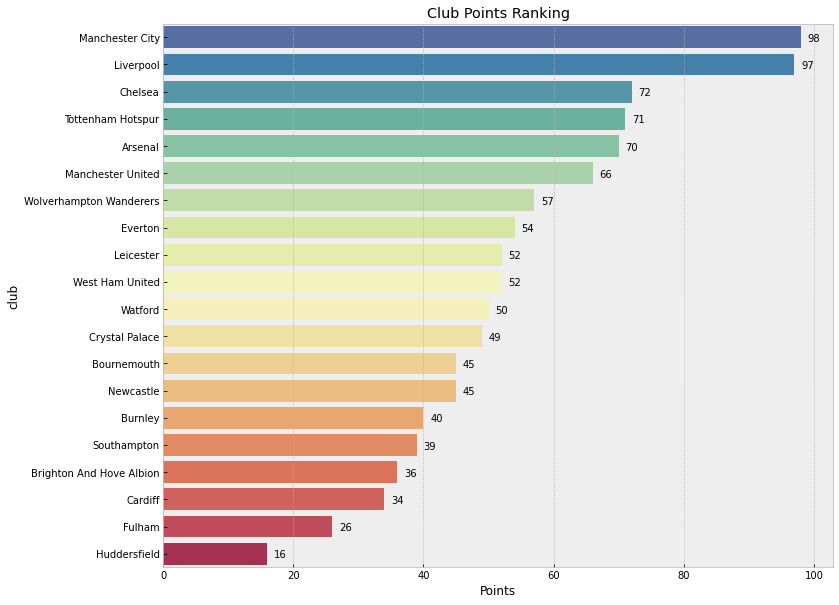

In [5]:
plt.figure(figsize = (12,10))

pal = sns.color_palette("Reds", len(table))

ax = sns.barplot(data = table, y = 'club', x = 'Pts' , palette= 'Spectral_r')
for p in ax.patches:
    width = int(p.get_width())
    plt.text(2+p.get_width(), p.get_y()+0.55*p.get_height(),
             width,
             ha='center', va='center')
plt.xlabel('Points')
plt.title('Club Points Ranking')
plt.show()

#### Clubs Goals Difference Ranking Graph

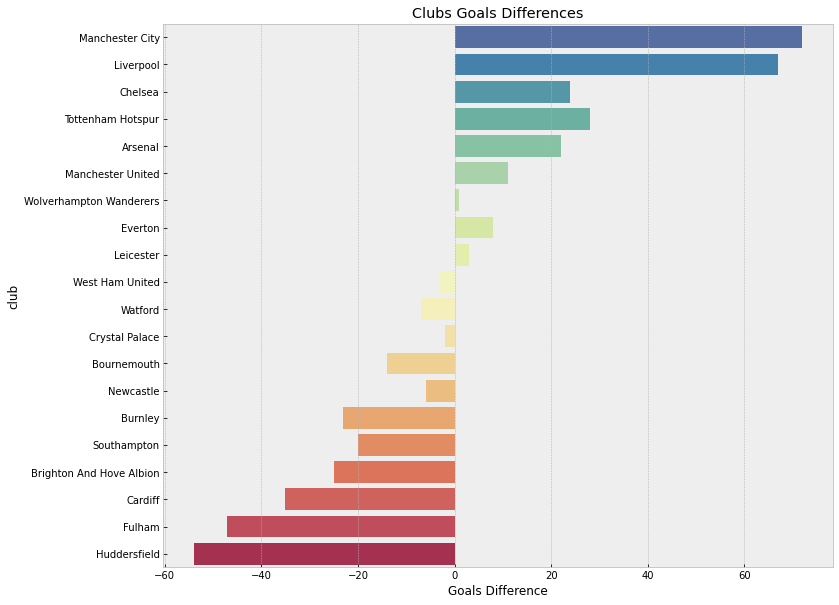

In [6]:
plt.figure(figsize = (12,10))
sns.barplot(x= 'GD', y= 'club', data= table, palette = 'Spectral_r')
plt.xlabel('Goals Difference')
plt.title('Clubs Goals Differences')
plt.show()

#### Attack vs defence graph 

* Here we mesure the Attack by goals for while we mesure the Defense by Goals Against

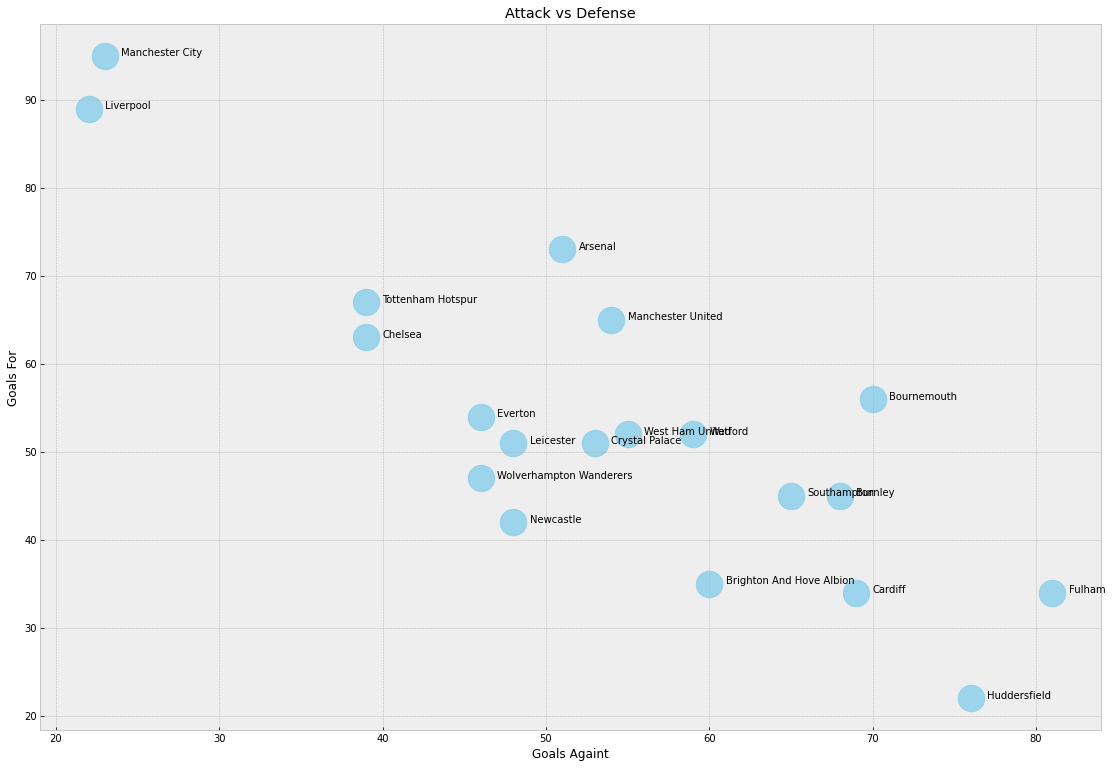

In [7]:
plt.figure(figsize=(19,13))
sns.regplot(x = table.GA, y = table.GF, data = table,fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':700})
plt.xlabel('Goals Againt')
plt.ylabel('Goals For')
plt.title('Attack vs Defense')
for line in range(0,len(table)):
    plt.text(table['GA'][line]+1, table['GF'][line], table['club'][line])

#### Evolution of teams points graph

* here we construct the initial table using sql and then we'll transforme it using pivot_table function

In [8]:
goals = pd.read_sql_query('''select game_date as date ,team_name, sum(points) over(partition by team_name order by game_id) as cumulative_points from
(select *, g.HOME_TEAM_ID as team_id, g.home_score as score, 
case 
 when g.HOME_SCORE > g.AWAY_SCORE then 3 
 when g.HOME_SCORE = g.AWAY_SCORE then 1
 else 0
 end as points
 from game g 
union all 
select *, gg.AWAY_TEAM_ID as team_id, gg.away_score as score ,
case 
 when gg.AWAY_SCORE > gg.HOME_SCORE then 3 
 when gg.AWAY_SCORE = gg.HOME_SCORE then 1 
 else 0
 end as points
from game gg
) as x
join team t
on x.TEAM_ID = t.TEAM_ID''', mydb, dtype = {'cumulative_points' : int})
top_5 = table['club'][:5]
cum_goals = goals.pivot_table(index = 'date',columns = 'team_name', values= 'cumulative_points', aggfunc='first' )[top_5]
cum_goals = cum_goals.fillna(method='ffill')

<ipython-input-8-2900d14037a7>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  goals = pd.read_sql_query('''select game_date as date ,team_name, sum(points) over(partition by team_name order by game_id) as cumulative_points from


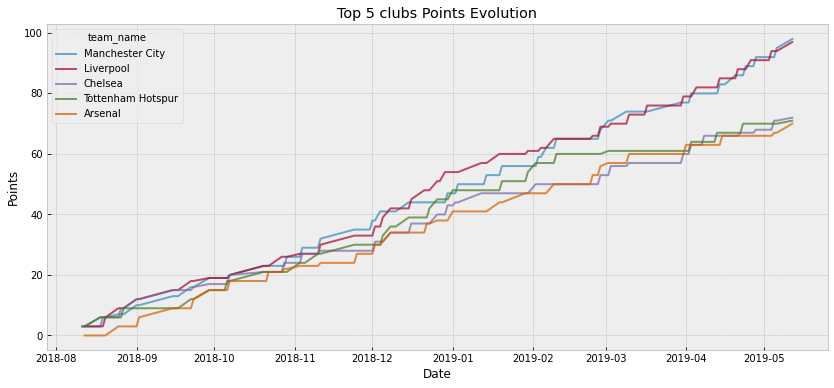

In [9]:
cum_goals.plot(figsize = (14,6),alpha=.7, lw=2)
plt.xlabel('Date')
plt.ylabel('Points')
plt.title('Top 5 clubs Points Evolution')
plt.show()

### 4- Players Analysis

#### Top Scorers table

In [10]:
top_scorers = pd.read_sql_query('''SELECT rank() over(order by sum(GOAL_ORDER) desc) as '',n.NATION_NAME as NAT, t.TEAM_NAME as CLUB, p.player_name as NAME ,count(GOAL_ORDER) as GOALS from goal g
join player p
on p.player_id = g.player_id
join nation n 
on n.NATION_ID = p.NATION_ID
join team t 
on t.TEAM_ID = p.TEAM_ID
group by p.player_id order by GOALS desc limit 10''', mydb,dtype = {'GOALS' : int} )
top_scorers

<ipython-input-10-4ebc72ede1bb>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_scorers = pd.read_sql_query('''SELECT rank() over(order by sum(GOAL_ORDER) desc) as '',n.NATION_NAME as NAT, t.TEAM_NAME as CLUB, p.player_name as NAME ,count(GOAL_ORDER) as GOALS from goal g


,,NAT,CLUB,NAME,GOALS
0,1,Gabon,Arsenal,Pierre-Emerick Aubameyang,22
1,2,Egypt,Liverpool,Mohamed Salah,22
2,3,Senegal,Liverpool,Sadio Mane,22
3,4,Argentina,Manchester City,Sergio Aguero,21
4,6,England,Leicester,Jamie Vardy,18
5,5,England,Manchester City,Raheem Sterling,17
6,7,England,Tottenham Hotspur,Harry Kane,17
7,13,Belgium,Chelsea,Eden Hazard,16
8,9,England,Bournemouth,Callum Wilson,14
9,8,England,Burnley,Ashley Barnes,13


#### Top scorers graph

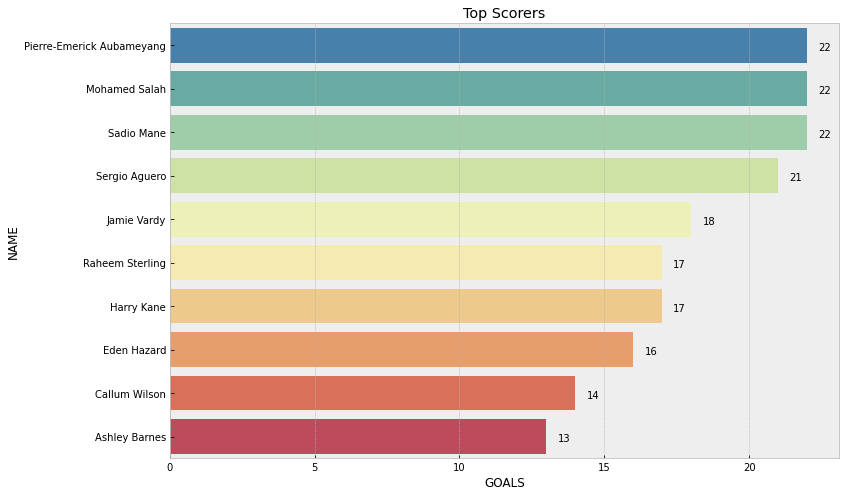

In [11]:
plt.figure(figsize = (12,8))
ax = sns.barplot(data = top_scorers, y = 'NAME', x = 'GOALS', palette = 'Spectral_r')
for p in ax.patches:
    width = int(p.get_width())
    plt.text(0.6+p.get_width(), p.get_y()+0.55*p.get_height(),
             width,
             ha='center', va='center')
plt.title('Top Scorers')
plt.show()

#### Players goals Evolution

In [12]:
players_goals=pd.read_sql_query('''SELECT p.PLAYER_NAME ,count(g.GOAL_ORDER) over(partition by g.PLAYER_ID order by gg.GAME_DATE) as Goals, gg.GAME_DATE FROM goal g
join game gg
on g.GAME_ID = gg.GAME_ID
join player p
on p.PLAYER_ID = g.PLAYER_ID''', mydb)
top_scorers_names = top_scorers['NAME'].tolist()
players_goals_cuml = players_goals.pivot_table(index = 'GAME_DATE',
         columns = 'PLAYER_NAME', values = 'Goals', aggfunc='first')[top_scorers_names[:5]]
players_goals_cuml = players_goals_cuml.fillna(method = 'ffill')

<ipython-input-12-60f4ae1a061d>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  players_goals=pd.read_sql_query('''SELECT p.PLAYER_NAME ,count(g.GOAL_ORDER) over(partition by g.PLAYER_ID order by gg.GAME_DATE) as Goals, gg.GAME_DATE FROM goal g


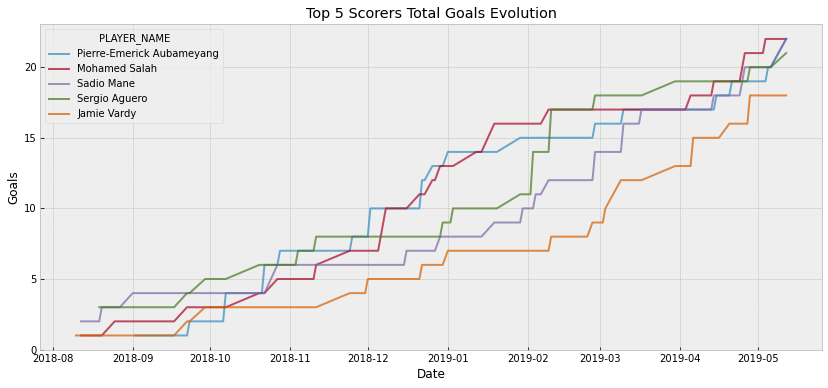

In [13]:
players_goals_cuml.plot(figsize = (14,6),alpha=.7, lw=2)
plt.xlabel('Date')
plt.ylabel('Goals')
plt.title('Top 5 Scorers Total Goals Evolution')
plt.show()